In [29]:
import pickle
import warnings

import matplotlib.pyplot as plt
import pandas as pd
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter("ignore", (SettingWithCopyWarning, FutureWarning))

In [14]:
# Read the pickle file
with open("../tracker_stubs/ball_detections.pkl", "rb") as f:
    ball_positions = pickle.load(f)

ball_positions = [x.get(1, []) for x in ball_positions]
df = pd.DataFrame(ball_positions, columns=["x1", "y1", "x2", "y2"])
df = df.interpolate()
df = df.bfill()
df["mid_y"] = (df["y1"] + df["y2"]) / 2
df["mid_y_rolling_mean"] = df["mid_y"].rolling(5, min_periods=1, center=False).mean()

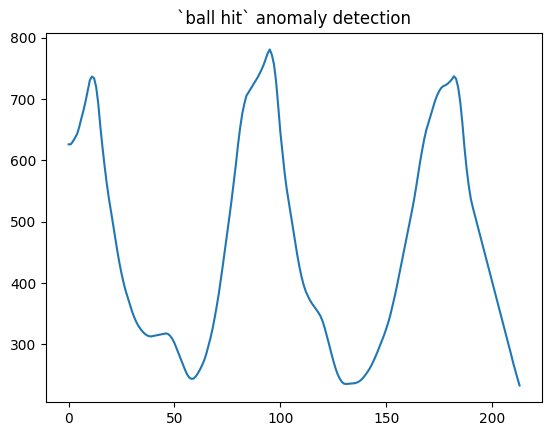

In [25]:
# Plot with a title
plt.title("`ball hit` anomaly detection")
plt.plot(df["mid_y_rolling_mean"])

In [23]:
df["delta_y"] = df["mid_y_rolling_mean"].diff()

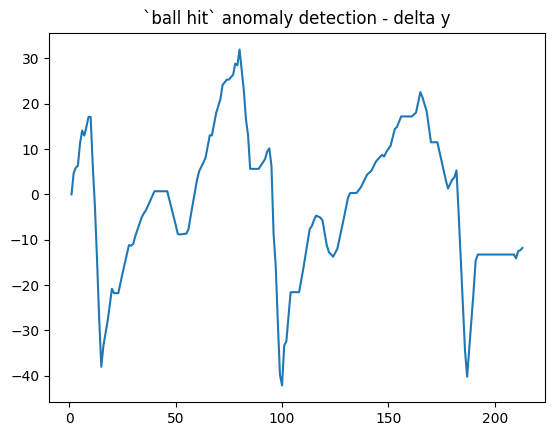

In [27]:
plt.title("`ball hit` anomaly detection - delta y")
plt.plot(df["delta_y"])

In [37]:
df["ball_hit"] = 0
minimum_change_frames_for_hit = 25
for i in range(1, len(df) - int(minimum_change_frames_for_hit * 1.2)):
    negative_position_change = (
        df["delta_y"].iloc[i] > 0 and df["delta_y"].iloc[i + 1] < 0
    )
    positive_position_change = (
        df["delta_y"].iloc[i] < 0 and df["delta_y"].iloc[i + 1] > 0
    )

    if negative_position_change or positive_position_change:
        change_count = 0
        for change_frame in range(
            i + 1, i + int(minimum_change_frames_for_hit * 1.2) + 1
        ):
            negative_position_change_following_frame = (
                df["delta_y"].iloc[i] > 0 and df["delta_y"].iloc[change_frame] < 0
            )
            positive_position_change_following_frame = (
                df["delta_y"].iloc[i] < 0 and df["delta_y"].iloc[change_frame] > 0
            )
            
            if negative_position_change and negative_position_change_following_frame:
                change_count += 1
            elif positive_position_change and positive_position_change_following_frame:
                change_count += 1

            if change_count >= minimum_change_frames_for_hit:
                df["ball_hit"].iloc[i] = 1
                break

In [38]:
df[df["ball_hit"] == 1]

,x1,y1,x2,y2,mid_y,mid_y_rolling_mean,delta_y,ball_hit
11,778.675537,718.305542,796.598022,737.032959,727.669250,736.640674,6.232568,1
58,925.987793,240.863223,938.989563,253.870065,247.366644,243.616025,-2.149662,1
95,616.823120,771.549438,639.405273,799.797119,785.673279,780.754871,6.316992,1
131,717.904663,229.931808,729.261414,241.865456,235.898632,235.281996,-0.691926,1
182,1295.720581,740.937012,1312.743408,758.546997,749.742004,737.110556,5.301562,1


In [39]:
df[df["ball_hit"] == 1].index.tolist()

[11, 58, 95, 131, 182]

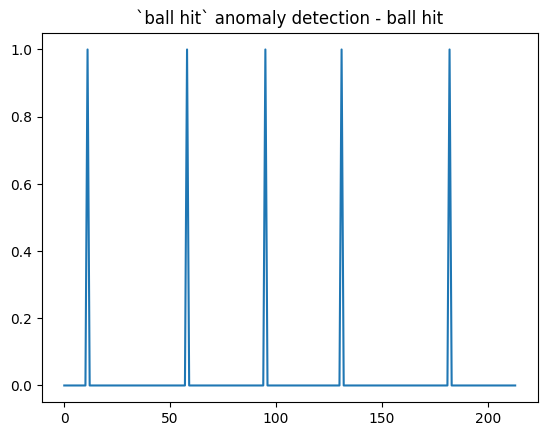

In [40]:
plt.title("`ball hit` anomaly detection - ball hit")
plt.plot(df["ball_hit"])